In [12]:
from py_hd_wallet import wallet
import eel
import re
from urllib.request import Request, urlopen
import json
import hashlib



import scrypt

from constants import *
from web3 import Web3
import os 
from dotenv import load_dotenv
from eth_account import Account 
import subprocess
import json
from bit import Key, PrivateKey, PrivateKeyTestnet
from bit.crypto import ECPrivateKey
from bit.curve import Point
from bit.format import (
    bytes_to_wif, public_key_to_address, public_key_to_coords, wif_to_bytes
)
from bit.network import NetworkAPI, get_fee_cached, satoshi_to_currency_cached
from bit.network.meta import Unspent
#from bit.transaction import calc_txid, create_p2pkh_transaction, sanitize_tx_data
from web3.middleware import geth_poa_middleware


#eel.init('web')


#Wallet Functions

#@eel.expose
def create_seed():
    seed = re.sub("[^\w]", " ",  wallet.generate_mnemonic()).split()
    count = 0
    seed_dict = {}
    for word in seed:
        count += 1
        word_count = "word" + str(count)
        seed_dict.update( {word_count : word} )
    return seed_dict

def derive_wallets(mnemonic, coin, nkeys):

    command = f'./hd-wallet-derive/hd-wallet-derive.php --mnemonic="{mnemonic}" --coin={coin} --numderive={nkeys}  --format=json -g'
    available_coins = "./hd-wallet-derive.php --help-coins" # --> currently not in use
    new_process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

    (output, err) = new_process.communicate()

    p_status = new_process.wait()

    if err:
        print("\nError:###\n\n")
        return err

    return json.loads(output)

#@eel.expose
def get_wallets(seed):
    """
    coins = ['BTC','BTG','BCH','LTC','DASH','DOGE','XRP','ZCASH','XLM']
    coin_purse = {}
    for coin in coins:
        w = wallet.create_wallet(network=coin, seed=seed, children=1)
        coin_purse.update({
            coin : {"address": w['address'],
                   "privatek": w["xprivate_key"],
                   "publick" : w["xpublic_key"],
                   "children": w["children"]
                   }
        })"""
    coin_purse = {  #We'll have to add more coins, specially ERC20 tokens
    "ETH"     : derive_wallets(seed, "ETH", 10), 
    "BTC-test": derive_wallets(seed, "BTC-test", 10),
    "BTC"     : derive_wallets(seed, "BTC", 10),
    "BTG"     : derive_wallets(seed, "BTG", 10),
    "BCH"     : derive_wallets(seed, "BCH", 10),
    "LTC"     : derive_wallets(seed, "LTC", 10),
    "DASH"    : derive_wallets(seed, "DASH", 10),
    "DOGE"   : derive_wallets(seed, "DOGE", 1),
    #"XRP"     : derive_wallets(seed, "XRP", 1),
    "ZEC"   : derive_wallets(seed, "ZEC", 1),
    #"XML"     : derive_wallets(seed, "XML", 1),
}
    return coin_purse

#@eel.expose
def priv_key_to_account(coin, priv_key):
    
    """Use it like this: my_btctest_account = priv_key_to_account("btc-test",coin_purse["btc-test"][0]["privkey"])"""
    if coin == "ETH":        return Account.privateKeyToAccount(priv_key)       
    elif coin == "btc-test": return PrivateKeyTestnet(priv_key)  
    elif coin == "BTC":      return PrivateKey(priv_key) 
    else:                    return "Not a supported coin"

    
def create_tx(coin, account, to, amount):
    """
    coin options: eth, btc-test, btc.
    account: account containing all the info like private and public 
    key as well as address of a certain account. This must be obtained
    trough the method priv_key_to_account().
    to: address to transfer funds.
    amount: amount of the currency. Take into account that Ether must 
    be expressed in weis.
    """
    if coin == "ETH":
        gas_estimate = w3.eth.estimateGas(
            {
                "from": account.address,
                "to": to,
                "value": amount
            }
        )

        return {
            "from": account.address,
            "to": to,
            "value": amount,
            "gasPrice": w3.eth.gasPrice,
            "gas": gas_estimate,
            "nonce":w3.eth.getTransactionCount(account.address)
        }

    elif coin == "btc-test":
        return PrivateKeyTestnet.prepare_transaction(account.address, [(to, amount, BTC)])
    
    elif coin == "BTC":
        return PrivateKey.prepare_transaction(account.address, [(to, amount, BTC)])
    
    else:
        return "Not a supported coin"

#@eel.expose
def send_tx(coin, account, to, amount):
    """
    coin options: eth, btc-test.
    account: account containing all the info like private and public 
    key as well as address of a certain account. This must be obtained
    trough the method priv_key_to_account().
    to: address to transfer funds.
    amount: amount of the currency. Take into account that Ether must 
    be expressed in weis.
    Example: send_tx(coin = "btc-test",account = my_btctest_account, to = coin_purse["btc-test"][1]["address"],amount= 0.01)
    """  
    tx = create_tx(coin, account.address, to, amount)
    signed_tx = account.sign_transaction(tx) #how to do this tho
    
    if coin == "ETH": 
        result = w3.eth.sendRawTransaction(signed_tx.rawTransaction)
        return result.hex()
    
    elif coin == "btc-test":
        result = NetworkAPI.broadcast_tx_testnet(signed_tx)
        return result
    
    elif coin == "BTC":
        result = NetworkAPI.broadcast_tx(signed_tx)
        return result
    
    else:
        return "Not a supported coin"
    

#@eel.expose
def get_balance(coin, account):
    
    if coin == "ETH": 
        return w3.eth.getBalance(account.address)
         
    
    elif coin == "btc-test" or coin == "btc":
        return account.get_balance("btc")
    
    else:
        return "Not a supported coin"

    
    
    
#Dashboard Functions

def read_json(url):
    request = Request(url)
    response = urlopen(request)
    data = response.read()
    url2 = json.loads(data)
    return url2

#@eel.expose
def get_prices(ticker_list = ['BTC','BTG','BCH','LTC','DASH','DOGE','XRP','ZEC','XLM']): 
    # Leaving this an argument instead of fixed string for flexibility, can be simpler/faster with fixed url input
    ticker_string=""
    for ticker in ticker_list:
        ticker_string += ticker+","
    url = f"https://min-api.cryptocompare.com/data/pricemulti?fsyms={ticker_string}&tsyms=USD"
    price_data = read_json(url)
    return price_data


# Password Functions

def hash_pass(pass_w):
    #return hashlib.sha256(bytes(pass_w, 'utf-8')).hexdigest() #Original
    return scrypt.encrypt(pass_w , 'Josh Eric Christian Oscar', maxtime=0.2)

#@eel.expose
def set_password(pass_w):
    file = open(".pwd", "w")
    file.write(hash_pass(pass_w))
    file.close()
    return True

#@eel.expose
def check_password(pass_w):
    file = open(".pwd", "r")
    """
    ######Original ######
    if file.read() == hash_pass(pass_w): 
    
        return 'True'
    else:
        return 'False' 
        """
    return scrypt.decrypt(file.read(),'Josh Eric Christian Oscar',maxtime=0.4) == pass_w


#eel.start('loginWindow.html', size=(1350, 750))

In [18]:
#seed = create_seed()

In [19]:
seed

{'word1': 'ready',
 'word2': 'plastic',
 'word3': 'ethics',
 'word4': 'debate',
 'word5': 'absorb',
 'word6': 'gaze',
 'word7': 'join',
 'word8': 'series',
 'word9': 'latin',
 'word10': 'certain',
 'word11': 'worth',
 'word12': 'offer'}

In [21]:
real_seed = ""
real_seed = [real_seed + seed[x] for x in seed]
real_seed = " ".join(real_seed)
real_seed

'ready plastic ethics debate absorb gaze join series latin certain worth offer'

In [144]:
coin_purse = get_wallets(real_seed)

In [140]:
coin_purse

{'ETH': [{'path': "m/44'/60'/0'/0/0",
   'address': '0x59C77f53Bd3E515884beE6505ADe7f05F80419e2',
   'xprv': 'xprvA35AcWmf6UB7HwGk11GVV7KpeLijVmUY4HG2rTBYUhbdYD7GYcEkf3WDUTDJJoVTwQQYzJZ94JzpdVgu4Tnx5pN4SEVTtjRBRgW5D1fypfz',
   'xpub': 'xpub6G4X22JYvqjQWRMD72oVrFGZCNZDuECPRWBdeqbA338cR1SR69Z1CqphKkvPWqfBVfhrBVX1nwZtt87DgfyU3UxZqx6CvAe3yV5JqHHZCUv',
   'privkey': '0x78dd3b7095152d111b02e8170e732b5bfaccfa61abbee83db7d2066c74bcd3cb',
   'pubkey': '03d98b98600a3c9d5822024a6a1d6a763d368c243225dc44c0b97d6c2ea9f36993',
   'pubkeyhash': 'ee24186bf061f9f4ac13098f636d9ad62c812ddc',
   'index': 0},
  {'path': "m/44'/60'/0'/0/1",
   'address': '0x33b1856eB6172936a5B8b6Db1ABB06592D980198',
   'xprv': 'xprvA35AcWmf6UB7NYQu4GVqiGqVhX4L9aQCEZCNAqJjwzy5AXzHNyRHfreeF5yek3f8RKeLCcJo5ng24prRwcfH9EhKrugqzC6nEM5AGCsRmvV',
   'xpub': 'xpub6G4X22JYvqjQb2VNAJ2r5QnEFYtpZ383bn7xyDiMWLW43LKRvWjYDey86P1uvTHw55NkBcjzFDbcVNPTdZ6AzAVCM6TGXZgFnW3kNmvQtJE',
   'privkey': '0x45ec17346bb687090a4b2971c0a6977c0a644db5c63e14

In [91]:
import qrcode

In [115]:
img = qrcode.make(coins["btc-test"][0]["address"])

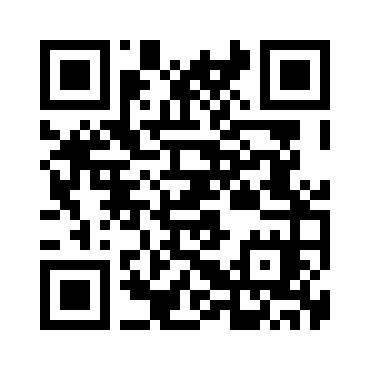

In [116]:
img

In [112]:
my_btctest_account = priv_key_to_account("btc-test",coins["btc-test"][0]["privkey"])
#my_btc_account = priv_key_to_account("BTC",privkey)

In [113]:
my_btctest_account

<PrivateKeyTestnet: mpChnAKRoQjSLFnQ68gCAnUoanYq4Kb4Hb>

In [114]:
my_btctest_account.address

'mpChnAKRoQjSLFnQ68gCAnUoanYq4Kb4Hb'

In [117]:
get_balance("btc-test", my_btctest_account)

'0.02'

In [122]:
send_tx(coin = "btc-test",account = my_btctest_account, to = coins["btc-test"][1]["address"],amount= 0.01)

In [119]:
 coins["btc-test"][1]["address"]

'mnjmEBahguS742TYvRgBdQX3NJfhb5iHLQ'

In [123]:
my_other_btctest_account = priv_key_to_account("btc-test",coins["btc-test"][1]["privkey"])

In [124]:
get_balance("btc-test", my_other_btctest_account)

'0.01'

In [125]:
get_balance("btc-test", my_btctest_account)

'0.00997008'

In [146]:
# Now let's try to create a specific child without creating the whole chain.

In [210]:
def tes_derive_wallets(mnemonic, coin, nkeys, specific=False):

    command = f'./hd-wallet-derive/hd-wallet-derive.php --mnemonic="{mnemonic}" --coin={coin} --numderive={nkeys}  --format=json -g'
    path_opt = " --path=m/44'/3'"
    available_coins = "./hd-wallet-derive.php --help-coins" # --> currently not in use
    
    if specific : new_process = subprocess.Popen(command+path_opt, stdout=subprocess.PIPE, shell=True)
    else: new_process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

    (output, err) = new_process.communicate()

    p_status = new_process.wait()

    if err:
        print("\nError:###\n\n")
        return err

    #return json.loads(output)
    return output

In [211]:
test = tes_derive_wallets(real_seed, "BTC-test", 1,True)

In [212]:
test

b'\n{"path":"m\\/44\\/3\\/0","address":"mz6bZNLJxq8N5dGpeRHcuKB2b7MsK7jxLW","xprv":"tprv8ggH6NM7ehUUdy6XN6C6UQYWFZ4r6KvsRxYCCpUMQQJcaaYkvKoR2G9UbFZ52vRWeB4DdprvLMkgaHsQexqEk6sqtAnQy2cbsqmL9bregq9","xpub":"tpubDDNKEnPMo5A9XS8KFjrgspCcpaanFf7n1G8yVLWepg71R4oXYid1CkmLmRCKvooVcu45zcLctRg1feGL6qtUZ7srQPjoLL68N6D2k97fzoi","privkey":"cPvozX6Sn3bVm7xLjANX4iJYhye2eAfEyAG5NoMwFfCw7FoPqAPU","pubkey":"03a90e7075fc0d11222957dd61f9a05ce1320f66c6acd9c9bf6e37ace8b84abbc1","pubkeyhash":"cbcf18e8febc3c3234fe97f86d0a99f654b1cda7","index":0}'

In [209]:
coin_purse["BTC-test"]

[{'path': "m/44'/1'/0'/0/0",
  'address': 'mpChnAKRoQjSLFnQ68gCAnUoanYq4Kb4Hb',
  'xprv': 'tprv8kG39HxK9185SojyCMVhPXAS9SdBdn9Ho9rVZiR4kN7YNCVMHVfhQVZtpteJR3ntvDnp9Hq1qPDbJa2wpCwNveDoyseNb5N9rUgddXNpeH3',
  'xpub': 'tpubDGx5HhzZHNokLGmm61AHnvpYiU97o7LCNTTGrETNAduwCgk7utVHazBm13xE43wtWRCZwu8ztNmZNsdYecY7H3KPVK4Mq2BPraLVse9Dauq',
  'privkey': 'cRkadzWgsEm6fWtSSwk8bqVKpoL7UCnkTVd4gAagUtFJGF6sgeBS',
  'pubkey': '03b3929b199a9e20e87b1a67182cb3c0edad99ce2d6d49f37968994f8339d0305e',
  'pubkeyhash': '5f458724ce63c7d1dc92d1c69d9e84c4b5729255',
  'index': 0},
 {'path': "m/44'/1'/0'/0/1",
  'address': 'mnjmEBahguS742TYvRgBdQX3NJfhb5iHLQ',
  'xprv': 'tprv8kG39HxK9185WSWsfd3zxHWTo4k33zXujmtRACwupSj2CGw7QmmMfu6fVVEyLcUCF2LMREqPUzDhDVtrhxAPAaS7xbkgNahv7RPXdfHwFL4',
  'xpub': 'tpubDGx5HhzZHNokPuYfZGibMhAaN6FyDKipK5VCSizDEiXR2mBt3AawrPiXfb2b98tXTYWr9w5HDPGimLsDcp1tQnEzyvzuegsQFRGhYXQFfPy',
  'privkey': 'cTK8JkY64F3p6jHoWKFkpSPmQKXqhhQtbNcC4aSa3dUrhriprFJ1',
  'pubkey': '02123f6dbc5c51bb115dd2881a3ca676

In [1]:
import wallet.py

Traceback (most recent call last):
  File "src/gevent/greenlet.py", line 766, in gevent._greenlet.Greenlet.run
  File "/anaconda3/lib/python3.7/site-packages/eel/__init__.py", line 257, in _process_message
    return_val = _exposed_functions[message['name']](*message['args'])
  File "/Users/oscareduardosernarosero/Documents/US/Rice U/Multi_Chain_GUI_Wallet/wallet.py", line 90, in get_wallets
    "ETH"     : derive_wallets(seed, "ETH", 10),
  File "/Users/oscareduardosernarosero/Documents/US/Rice U/Multi_Chain_GUI_Wallet/wallet.py", line 66, in derive_wallets
    return json.loads(output)
  File "/anaconda3/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/anaconda3/lib/python3.7/json/decoder.py", line 340, in decode
    raise JSONDecodeError("Extra data", s, end)
json.decoder.JSONDecodeError: Extra data: line 1 column 5 (char 4)
2020-01-14T18:41:37Z <Greenlet at 0x11a61f9d8: _process_message({'call': 3.4961585988575123, 'name': 'get_wall

SystemExit: 

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import scrypt
import pandas as pd
from path import Path

In [3]:
def hash_pass(pass_w,salt):
    #return hashlib.sha256(bytes(pass_w, 'utf-8')).hexdigest() #Original
    return scrypt.encrypt(pass_w , salt, maxtime=0.2)

def set_password(pass_w, seed):
    """
    file = open(".pwd.csv", "w")
    file.write(hash_pass(pass_w)) 
    file.close()
    """
    
    password = {"seed": [hash_pass(seed ,pass_w).hex()], #we encrypt the mnemonic seed with the password
               "password": [hash_pass(pass_w,"super wallet").hex()]} #ecnryption of the password with a salt
    psw_df = pd.DataFrame(password)
    pass_path = Path(f".pwd.csv")
    psw_df.to_csv(pass_path)
    return True

def check_password(pass_w):
    
    """
    ######Original ######
    file = open(".pwd", "r")
    if file.read() == hash_pass(pass_w): 
    
        return 'True'
    else:
        return 'False' 
        """
    pass_path = Path(f".pwd.csv")
    password = pd.read_csv(pass_path)
    ecnrypted_pass = bytes.fromhex(password["password"][0])
    print(ecnrypted_pass)
    decrypted = scrypt.decrypt(ecnrypted_pass,'super wallet',maxtime=0.4)
    print("\n"+decrypted)
    
    return decrypted == pass_w


In [5]:
set_password("password","b m a d")

True

In [6]:
check_password("password")

b'scrypt\x00\x10\x00\x00\x00\x08\x00\x00\x00\x01\xd6\xb7\x8ed\x80V\xc1\xa6\xa1\xd7\x85c`\x19\xc1z\x92\x9f\x8f\xa5`\xe2A6F\x17\xa5z\x82\x9f\x98*\xa9\x13\x89\xe92\x07s\x9e4i,+\x9f\x17\xe3\x02\x02\x85\xafVDc\x91\xec\xc0\xb7`N\xd1\xa9\tBh\xa7\x04\xcb*\x86lm\x10\x7f/\xc3\n\x86\x7fE0`\x99\xc5\xc0\x14\xe7t\x026\xc0\xbf:q\x1c\xd9H\xd5F\x94\xdf\x19 \x87\xe3\xba\x07\xe4\x7f\xad\xaf\xa32\xf4\x97\xf4H\xb6=\x18'

password


True

In [7]:
data = hash_pass("Test","super wallet")

In [8]:
decrypted = scrypt.decrypt(bytes.fromhex(password["seed"][0]),'password',maxtime=0.4)

NameError: name 'password' is not defined

In [9]:
decrypted

NameError: name 'decrypted' is not defined

In [10]:
data

b'scrypt\x00\x0f\x00\x00\x00\x08\x00\x00\x00\x01\xac@6s\x9bE\x91(l\x8b\xae\xb4\xd8\xf5\xd3\xc0\xa33\xa1\x98\x1d\xfe\x94\x19c,\x15\xea+\xc5\xcc\x1d\x9e\xbb\x8e\xc5\xc0\x07\xc6;Ih\x82\x1c.\xcdhG\x0b)\x17\x95\xb0W\x0b\xf2\xdb ,)\x1ckx\xbf/q\xc0\x1d\xa3.\xca\x89\xa5\xc7dM\x0b;\x1d!\xfb\x0e\x07+\x83\xaf\xa9I9\x0c\x90\xf4\xcd\x8bs\xcb;\xae\xd2x\x00X\xd1\xe9x\x8a\xd2\x99k@\xa8\xb8Q^\xc9l'

In [4]:
pass_path = Path(f".pwd.csv")
password = pd.read_csv(pass_path)

In [12]:
password["password"][0]

'73637279707400100000000800000001d6b78e648056c1a6a1d785636019c17a929f8fa560e241364617a57a829f982aa91389e93207739e34692c2b9f17e3020285af56446391ecc0b7604ed1a9094268a704cb2a866c6d107f2fc30a867f45306099c5c014e7740236c0bf3a711cd948d54694df192087e3ba07e47fadafa332f497f448b63d18'

In [44]:
type(password["password"][0])

str

In [24]:
type(data)

bytes

In [47]:
bytes.fromhex(password["password"][0])

b'scrypt\x00\x10\x00\x00\x00\x08\x00\x00\x00\x01\xf8\xda\xb3u\xa6\x90\xce\xc9\xb8\x9eKG\x07\xbf\x1fx\x89\x8e.\x9e\xfbA\xfe.\xc7\x1b\xd4\r\xad\x9cz\x06vU\xfc\x0b\xee\xce\x8c5\xc9\xe6m\xfa\x00\xb9\xe6;a\xb4\n\x1e_\t}W^\xeb\xd4Gr\x8a\x13\xbad|Cy\x84\x84\x16\x97\xbd\x98\x06\xc3P\xa56\x16+\x85\xd7\xa8\xa9\x92\xe0\xde\x18\xc1\xbe<pg\xf3u\x98\xfa\xdf!w\xe4\xaa\x1d\xba\xfb@\x07\x8e<\xaf\x8b\x0b!\xb5*\xdbS\xdf\xe7'

In [14]:
password.loc[0]["seed"]

'736372797074000f00000008000000011bb78acce0a508c9c8e2a91feb7ce4e625301763ee84714997b595bd43be213ce2577afcb863dd5857f592abcd8f4f2ddf9b3aaddcfd3bd4aca22c17515e7758c14f29bdd8ffdf6f60154e97cdc74ecd3493ddec4445d587f9ecc68abf242365024b38e1c589661d28281302103ff5f9e309146e660374'

In [5]:
decrypted = scrypt.decrypt(bytes.fromhex(password["seed"][0]),'Test2',maxtime=0.4)

In [6]:
decrypted

'guard silver popular tide height lemon sustain opera sweet type armed screen '

In [13]:
coins = get_wallets(decrypted)

In [14]:
coins

{'ETH': [{'path': "m/44'/60'/0'/0/0",
   'address': '0x8B987BEf21e3d115b35B6955021291A202f6AEFf',
   'xprv': 'xprvA3nZiqk15ESd18TummbdfKQeD3xHBc8TjX7hNf9ttTgoEYknTHMUYJShypAxyPgKSB34V8R7ZyGnr1bupeudsbdhAVAqW71t1BDgVPGGqkc',
   'xpub': 'xpub6Gmv8MGtubzvDcYNso8e2TMNm5nmb4rK6k3JB3ZWSoDn7M5vzpfj66mBq4ccTwoGyiZPnFSXftrb3ymFncjb2DadR26TXD9v6CnEMRKe1tx',
   'privkey': '0xfbdf88afb8de3d47be818700a7717d8f3f10b9df1ea060d957d00de7b04799a3',
   'pubkey': '02ae6662ee78f1a2974d92fe12753d5125d41807320239ba195b8d8ee62057cfc0',
   'pubkeyhash': '565c4ed6059a742954e039a22166f42de62b35a9',
   'index': 0},
  {'path': "m/44'/60'/0'/0/1",
   'address': '0xbc08D722c272D22eFdcdDbBEED6cd9c1567887d1',
   'xprv': 'xprvA3nZiqk15ESd3DocvbRvb8DNNQtQudiqPRdmR7r992Hm6ux3iBFxwqiPYgxatUymxURRotvz7nuVNyQfeCRr1Ro8Zywiyvj4VHAK2tkFXqt',
   'xpub': 'xpub6Gmv8MGtubzvFht62cxvxGA6vSiuK6SgkeZNDWFkhMpjyiHCFiaDVe2sPyqmVqYGW1nhau71LLnysi4svXG9sYz99QLe3LBLKDwGVow1m4o',
   'privkey': '0x6ad1fa5bbe07a83282708e25d0afe4a6f5b933895a5698